# This notebook illustrates how to annotate a fluorescent image  


In this notebook, we will annotate a fluorescent image of a IBEX protein multiplex imaging. 
We will load the image, and then annotate it using the annotation tool, either using semi-automatic annotation or manual annotation.
Annotations will be saved with the extension .pkl.

#### init and load image

In [1]:
import os
# os.environ['BOKEH_ALLOW_WS_ORIGIN']='0hu6k2kns32pmvebqpolnitgmdrp4frrrgp0kbqlu52no0hsu0l8'
os.environ['BOKEH_ALLOW_WS_ORIGIN']='*'
# os.environ['BOKEH_ALLOW_WS_ORIGIN']='localhost:8888'
import numpy as np 
from bokeh.plotting import show, output_notebook
import pandas as pd
import socket
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tissue_tag as tt
output_notebook()
host = '8888' # set the port to the value in the address bar

Loading BokehJS ...

## Load image and define annotation names and colors 

(2704, 3948)


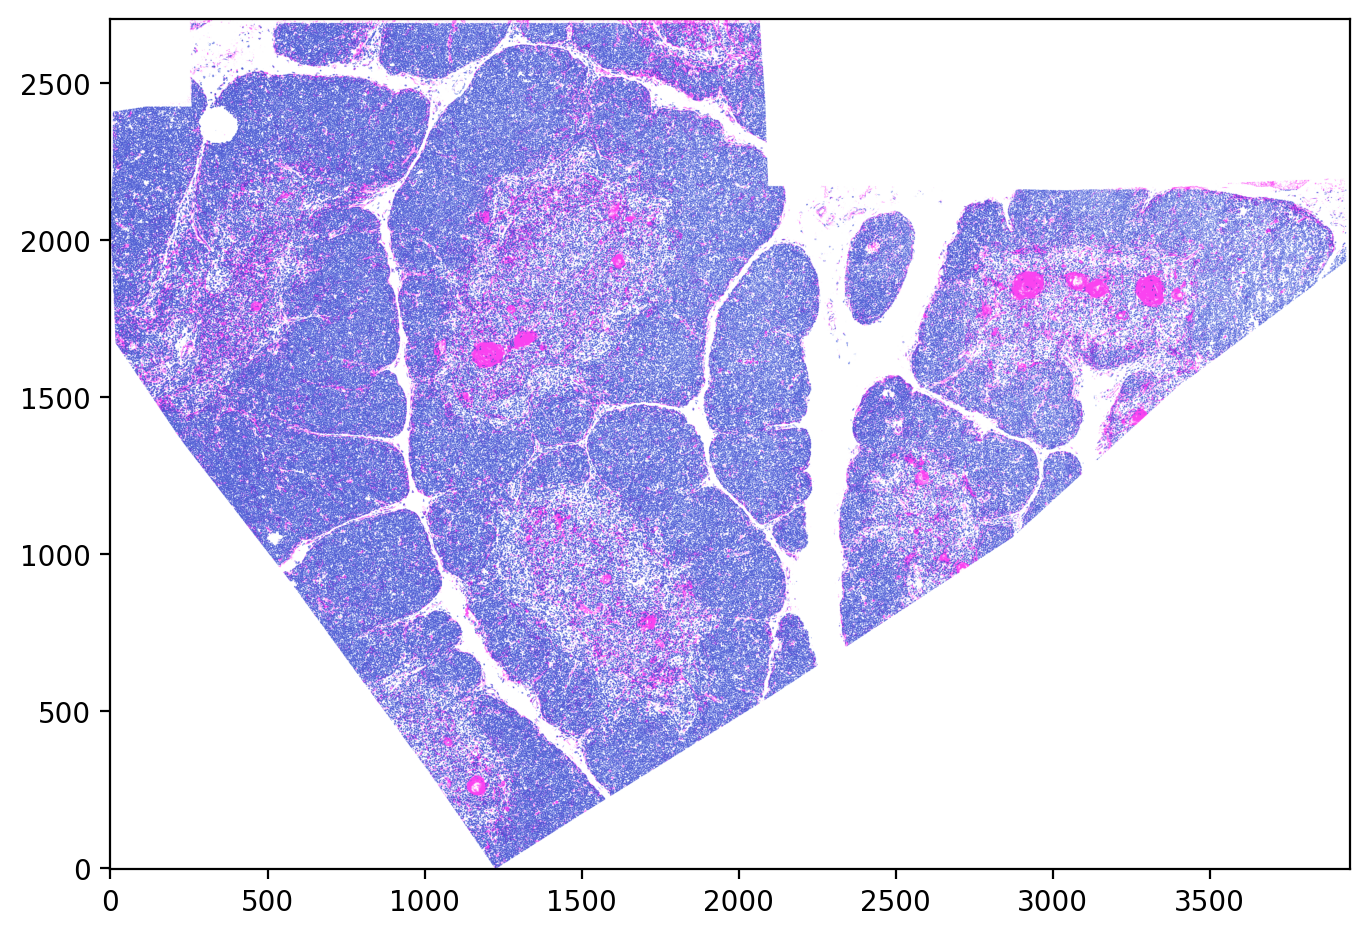

In [2]:
# here you can either read a single image (grayscale or RGB) or generate a virtual H&E from 2 images in the next cell
path_to_tissue_tag = # path to tissue tag main folder (e.g. c:/Users/John/Downloads/TissueTag)

path = path_to_tissue_tag + '/data/tissue_tag_minimal_example_ibex/' 
im,_,ppm = tt.read_image(path+'Sample_05_THY45_Z5_ch0009.jpg',contrast_factor=2,background_image_path=path+'Sample_05_THY45_Z5_ch0058.jpg',ppm_image=3.5198,ppm_out=1)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(im,origin='lower')

plt.show()

In [3]:
# define annotations 
annodict = {
    'unassigned':'yellow',
    'Artifacts':'black',
    'Medulla':'green',
    'Cortex':'cyan',
    'Edge':'brown',
    'HS':'magenta',
    'Vessels':'blue',
    'PVS':'red',
    'Other':'orange',
}

labels = np.ones((im.shape[0],im.shape[1]), dtype=np.uint8) # blank annotation image


From here there are two options:

1. Provide initial training labes of specific areas on the image and automatically predict the pixel identity for the rest of the image with a random forest pixel classifier

2. Annotate the image fully manually 

For (1) run both option .1 and option 2. For (2) run only option 2.

## Option 1
(1) scribble initial annotations - add initial annotations to the different areas (e.g. background, cells, etc.) 
these will be the training labels for the model that will automatically annotate the rest of the image

In [4]:
labels = np.ones((im.shape[0],im.shape[1]), dtype=np.uint8) # blank annotation image
p, render_dict = tt.scribbler(im,annodict)
def app(doc):
    global p
    doc.add_root(p)

show(app,notebook_url=f'{socket.gethostname()}:'+host) # determine if working on a server or local environment, if working on a local pc - 'local', while working on server instance indicate the port number e.g. 5011 (string)
print('wait for it.. can take a few tens of seconds on farm...')

wait for it.. can take a few tens of seconds on farm...


(2) extract and plot scribble anotations  

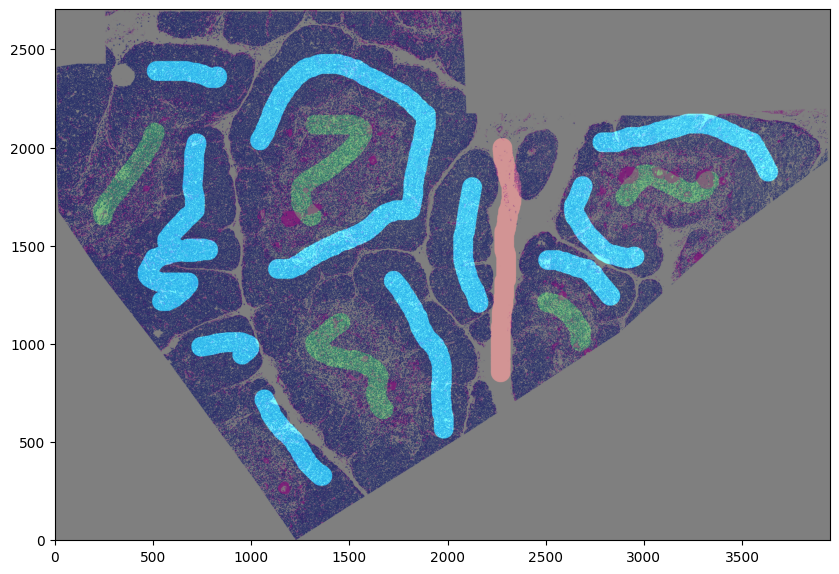

In [5]:
line_width = 100 # microns
labels = tt.scribble_to_labels(im,render_dict,line_width=line_width*ppm)
labels_rgb = tt.rgb_from_labels(labels,colors=list(annodict.values()))
tt.overlay_labels(im,labels_rgb,alpha=0.5);


(3) run the RF classifier 

CPU times: total: 4min 49s
Wall time: 45.8 s


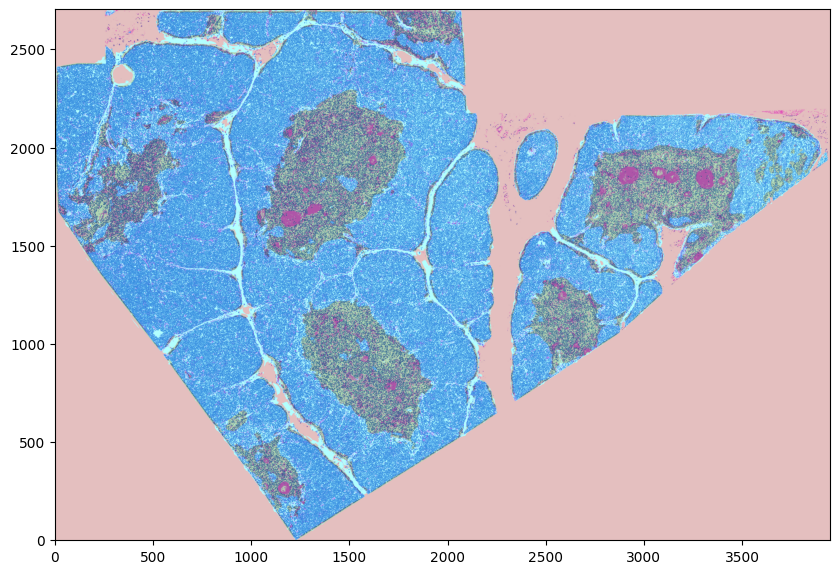

In [6]:
%%time
# this step takes about 30s to 5 min depending on number of training areas and resolution  
labels = tt.sk_rf_classifier(im, labels)
# plot result 
labels_rgb = tt.rgb_from_labels(labels,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,labels_rgb,alpha=0.7)

## Option 2
load the output of the Random Forest classifier from option 1 (if used it) and continue with manual corrections + annotation

In [9]:
# at this stage, if you are adding annotations make sure they come after the current ones otherwise it will mess up everything
labels_rgb = tt.rgb_from_labels(labels, colors=list(annodict.values()))
out_img = tt.overlay_labels(im,labels_rgb,alpha=0.5,show=False)

tabs,render_dict = tt.annotator(im,out_img,anno_dict=annodict)

# plotting
def app(doc):     
    global tabs
    doc.add_root(tabs)
show(app,notebook_url=f'{socket.gethostname()}:'+host)
print('wait for it.. can take a few tens of seconds on farm... (double time of the former plot)')

wait for it.. can take a few tens of seconds on farm... (double time of the former plot)


## update annotations 

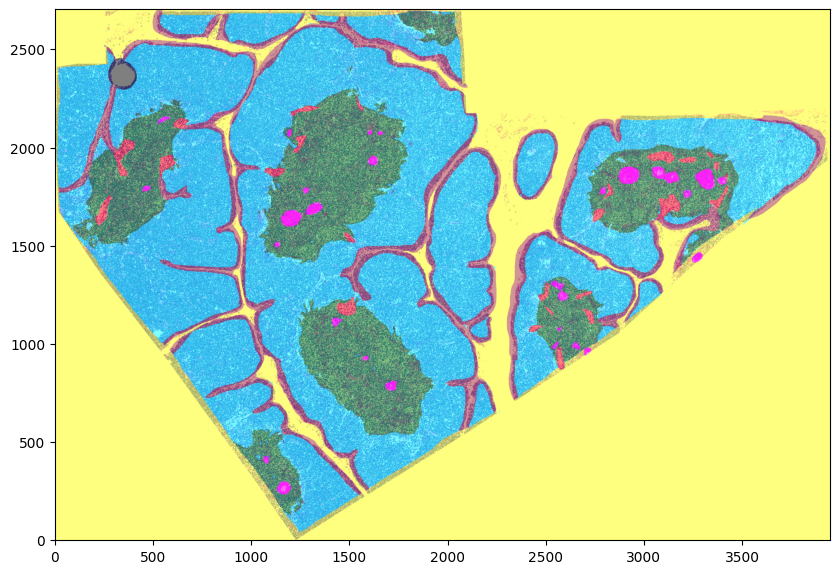

In [10]:
out_img, labels = tt.update_annotator(im,labels,anno_dict=annodict,render_dict=render_dict,alpha=0.5)
# plot result 
labels_rgb = tt.rgb_from_labels(labels,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,labels_rgb,alpha=0.5)

##  save annotations

In [12]:
isExist = os.path.exists(path+'tissue_annotations')
if not(isExist):
    os.mkdir(path+'/tissue_annotations/')
    
tt.save_annotation(
    folder=path+'/tissue_annotations/',
    label_image=labels,
    file_name='annotations',
    anno_names=list(annodict.keys()),
    anno_colors=list(annodict.values()),
    ppm = ppm,
    
)